In [24]:
# %matplotlib inline  # 图片嵌入模式
import random
import torch
from d2l import torch as d2l

In [25]:
###### 手动实现线性回归模型和优化 ########
###### 数据准备 ########
# w=[2,-3.4]T,b=4.2
# y = Xw + b + c （c为噪声）
# 根据已知参数生成数据集用以模拟
def synthetic_data(w, b, num_examples):
    # normal函数参数分别为，均值，标准差和size 作用是生成相关数据
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b  # matmul矩阵乘法，二维或一维时和mm类似
    y += torch.normal(0, 0.01, y.shape)  # 生成随机噪声c
    # print(y)
    return X, y.reshape((-1, 1))
    # -1表示该维度将从另一个维度进行推算出来
    # 这里(-1,1)表示1000行1列 也就是一个列向量


true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print(features[0], '\n', labels[0])

tensor([-1.2861, -0.4188]) 
 tensor([3.0523])


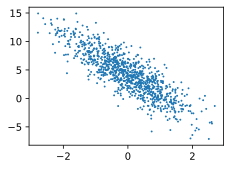

In [26]:
d2l.set_figsize()  # 打印矢量图并设置图的尺寸
d2l.plt.scatter(features[:, 1].detach().numpy(),
                labels.detach().numpy(), 1)
#有些版本转换numpy需要从计算图中detach出来,最后1表示点的大小
# print(labels.numpy())
# print(type(labels.numpy()))

In [27]:
# 选取小批量
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    index = list(range(num_examples))
    random.shuffle(index)  # 打乱一个python列表（原列表改变）
    # 以上三步是打乱索引顺序，为了随机挑选batch
    for i in range(0, num_examples, batch_size):
        batch_index = torch.tensor(
            index[i:min(i + batch_size, num_examples)])  # 防止超出范围
        yield features[batch_index], labels[batch_index]
        # 简单来说yield在下一次函数执行时保留上一次的运行环境并返回相关值
        # tensor可以直接通过其他tensor来提取其中相应索引的值


batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.3431,  0.9991],
        [-0.4579, -1.8134],
        [ 0.1838,  1.4410],
        [ 0.3216, -0.7108],
        [-0.2130,  1.3008],
        [ 1.1698, -0.4178],
        [ 0.2531,  0.1668],
        [ 0.4043,  1.8303],
        [-1.1125, -0.6475],
        [-0.3026,  0.8298]]) 
 tensor([[ 1.4813],
        [ 9.4626],
        [-0.3350],
        [ 7.2549],
        [-0.6299],
        [ 7.9736],
        [ 4.1466],
        [-1.2167],
        [ 4.1656],
        [ 0.7635]])


In [28]:
###### 模型部分 ########
# 初始化模型参数
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
w, b

(tensor([[-0.0172],
         [ 0.0135]], requires_grad=True),
 tensor([0.], requires_grad=True))

In [29]:
# 模型定义
def linreg(X, w, b):
    return torch.matmul(X, w) + b


# 损失函数
# 均方误差
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2  # 统一数据shape防止错误
# 实际上损失求不求平均都可以只不过平均以后将scale缩小到单个样本的大小了

In [30]:
# 定义优化算法
def sgd(params, lr, batch_size):
    with torch.no_grad():# 该语句表明后续计算不需要进行反向传播，强制后面不进行计算图构建
        for param in params:
            param -= lr * param.grad / batch_size # 这里把均方误差的除号移到这里了
            # 效果是一样的
            param.grad.zero_()

In [31]:
# 简单来说就分为4步
# 1.初始化参数
# 2.根据模型计算并计算损失
# 3.求损失关于参数的梯度
# 4.更新参数
lr = 0.03 # 学习率
num_epochs = 1000 # 梯度下降次数
net = linreg # 方便后续更换算法
loss = squared_loss

for epoch in range(num_epochs):
    # time = 0
    for X,y in data_iter(batch_size,features,labels):
        # 如果不break则每次大循环都更新100次梯度
        # 如果加break可以修改num_epochs为指定迭代次数
        l = loss(net(X,w,b),y) # 小批量损失
        l.sum().backward() # 计算梯度(因为对于每个参数都希望只有单一梯度故要求和，从一个损失向量到总损失)
        sgd([w,b],lr,batch_size) # 梯度更新函数
        break
        # time+=1
        # print(time)
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch{epoch +  1},loss{float(train_l.mean()):f}')

epoch1,loss15.099118
epoch2,loss13.999376
epoch3,loss13.334479
epoch4,loss12.933799
epoch5,loss11.837091
epoch6,loss11.433331
epoch7,loss10.517735
epoch8,loss9.543009
epoch9,loss9.024171
epoch10,loss8.354676
epoch11,loss7.764027
epoch12,loss7.093583
epoch13,loss6.665366
epoch14,loss6.280114
epoch15,loss5.957800
epoch16,loss5.715535
epoch17,loss5.439518
epoch18,loss4.921375
epoch19,loss4.615529
epoch20,loss4.340906
epoch21,loss4.173891
epoch22,loss3.940164
epoch23,loss3.776540
epoch24,loss3.498664
epoch25,loss3.275238
epoch26,loss3.120124
epoch27,loss3.030704
epoch28,loss2.916245
epoch29,loss2.794982
epoch30,loss2.691285
epoch31,loss2.493039
epoch32,loss2.418664
epoch33,loss2.255224
epoch34,loss2.067791
epoch35,loss1.927527
epoch36,loss1.785501
epoch37,loss1.698847
epoch38,loss1.593517
epoch39,loss1.478618
epoch40,loss1.406796
epoch41,loss1.297296
epoch42,loss1.253977
epoch43,loss1.161260
epoch44,loss1.078558
epoch45,loss1.006785
epoch46,loss0.929675
epoch47,loss0.836891
epoch48,loss0.7

In [32]:
print(f'w的估计误差：{true_w-w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([ 6.1154e-05, -1.7309e-04], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0001], grad_fn=<RsubBackward1>)
